<a href="https://colab.research.google.com/github/FaizanHameed1/Object-Detection-Traffic-Signs-Detection-with-YOLO-algorithm-/blob/main/Traffic_Signs_Detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
cd /content/gdrive/My Drive/Kaggle/traffic_signs_detection

/content/gdrive/My Drive/Kaggle/traffic_signs_detection


In [4]:
os.getcwd()

'/content/gdrive/My Drive/Kaggle/traffic_signs_detection'

In [5]:
#downloading dataset in drive
#!kaggle datasets download -d valentynsichkar/traffic-signs-dataset-in-yolo-format

In [6]:
#check the content in the directory
!ls

classes.names	      traffic-sign-to-test.mp4	yolov3_ts_test.cfg
data		      train.txt			yolov3_ts_train.cfg
getting-full-path.py  ts			yolov5
test.txt	      ts_data.data


In [7]:
#so we have downloaded the dataset(as it is zip file so we are going to extract and delete the old zip file)
#run only one time
#!unzip \*.zip  && rm *.zip

In [8]:
ls

classes.names         traffic-sign-to-test.mp4  yolov3_ts_test.cfg
data/                 train.txt                 yolov3_ts_train.cfg
getting-full-path.py  ts/                       yolov5/
test.txt              ts_data.data


In [9]:
#Directory of data
dataset_path="/content/gdrive/My Drive/Kaggle/traffic_signs_detection/ts/ts"

The data in dataset_path directory have two types.With every image there is a text file. At first position in each text file, the class is given and next four are the bounding box coordinates. This is the dataset type which YOLO algorithem takes as input.

In [10]:
from IPython.display import Image, display #to display immages and results
import tensorflow as tf
import torch as tr#yolov5 works on the top of pytorch
import tensorboard as tb
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [11]:
pwd #current working drectory

'/content/gdrive/My Drive/Kaggle/traffic_signs_detection'

In [12]:
#cloning the github repository for yolov5
#!git clone https://github.com/ultralytics/yolov5.git

In [13]:
ls #Now we can check that our repositery is downloaded with the name of yolov5

classes.names         traffic-sign-to-test.mp4  yolov3_ts_test.cfg
data/                 train.txt                 yolov3_ts_train.cfg
getting-full-path.py  ts/                       yolov5/
test.txt              ts_data.data


In [14]:
%cd yolov5 

/content/gdrive/My Drive/Kaggle/traffic_signs_detection/yolov5


In [15]:
#we have to install requirements(with name requirements.txt) file that exist in the folder yolov5 with the
!pip install -r requirements.txt

     |████████████████████████████████| 636 kB 5.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


As we can see that our whole data is in single folder so, we have to divide it into train and validation also yolov5 required dataset in this format.We will convert this dataset in four folders i.e in train,validation and train labels and validation labels.

In [16]:
#first of all we have to split images and text files
images=[]
text_files=[]

for file_ in os.listdir(dataset_path):
  if file_.endswith(".jpg"):

    images.append(file_)
  else: 
    text_files.append(file_)

#total immages and text files
total_images=len(images)
total_annotations=len(text_files)
print(f"total images:{total_images}")
print(f"total text files: {total_annotations}")

total images:741
total text files: 741


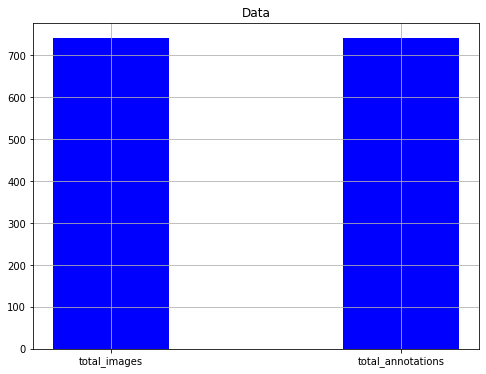

In [17]:
#Showing graphically the number of images and annotation files
dict_={"total_images":len(images),"total_annotations":len(text_files)}
keys=dict_.keys()
values=dict_.values()

plt.figure(figsize=(8,6))
plt.bar(keys,values,width=0.4, color="blue")

plt.title("Data")
plt.grid()
plt.show()

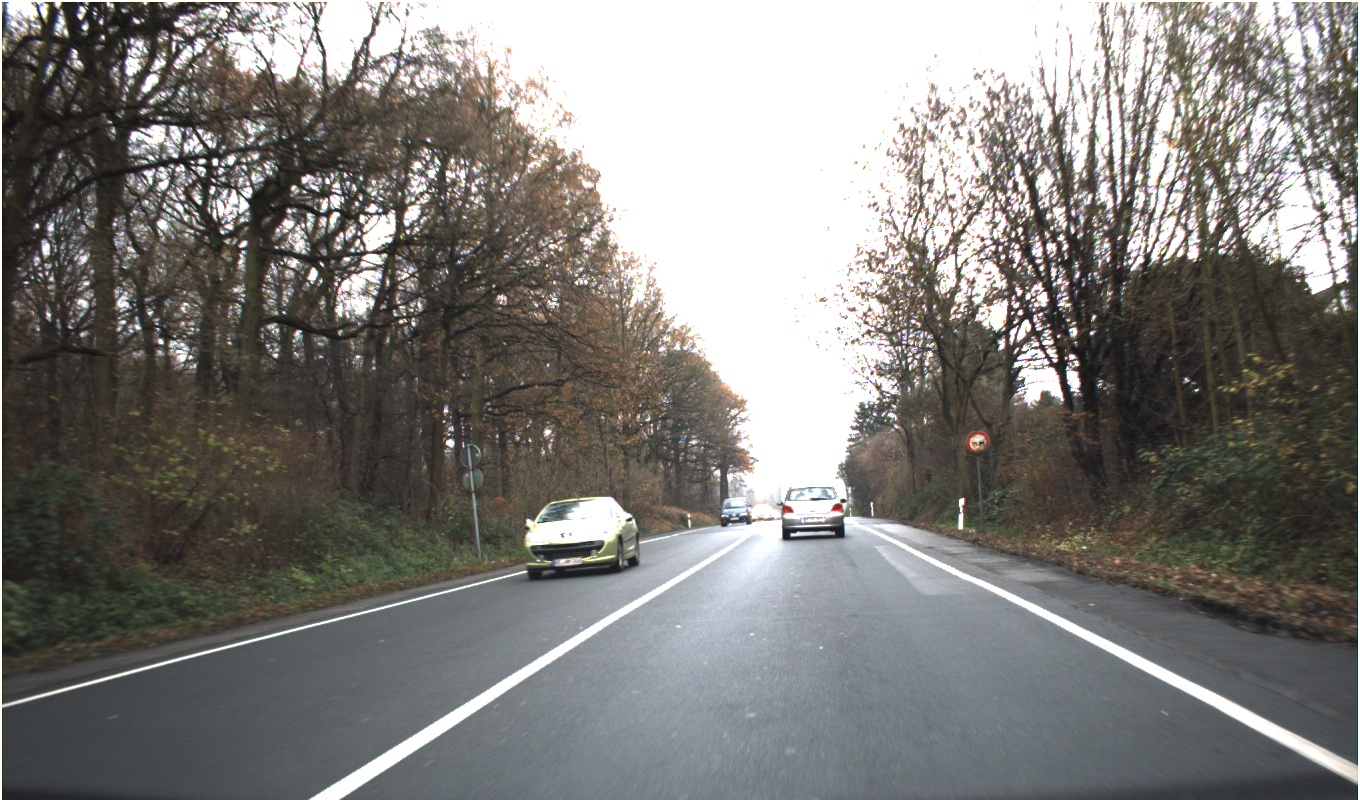

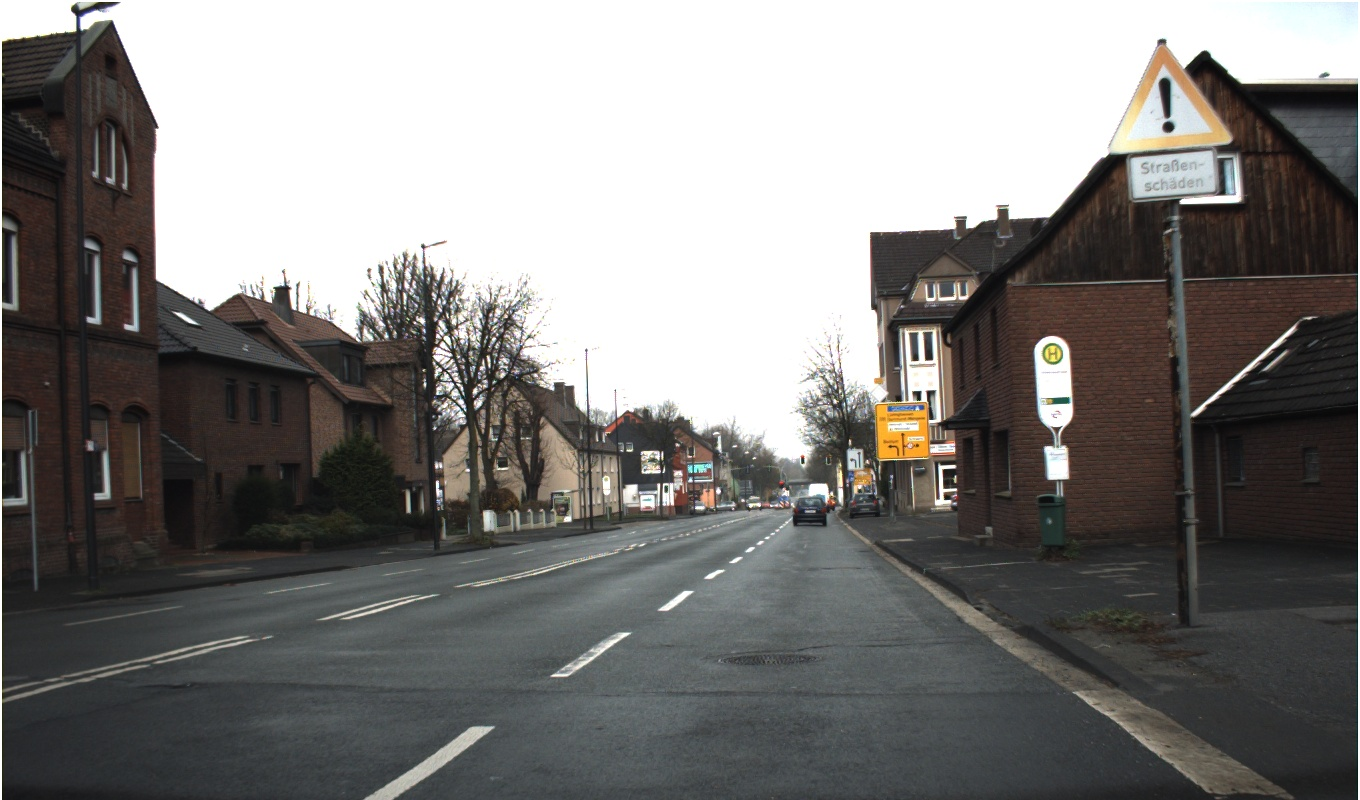

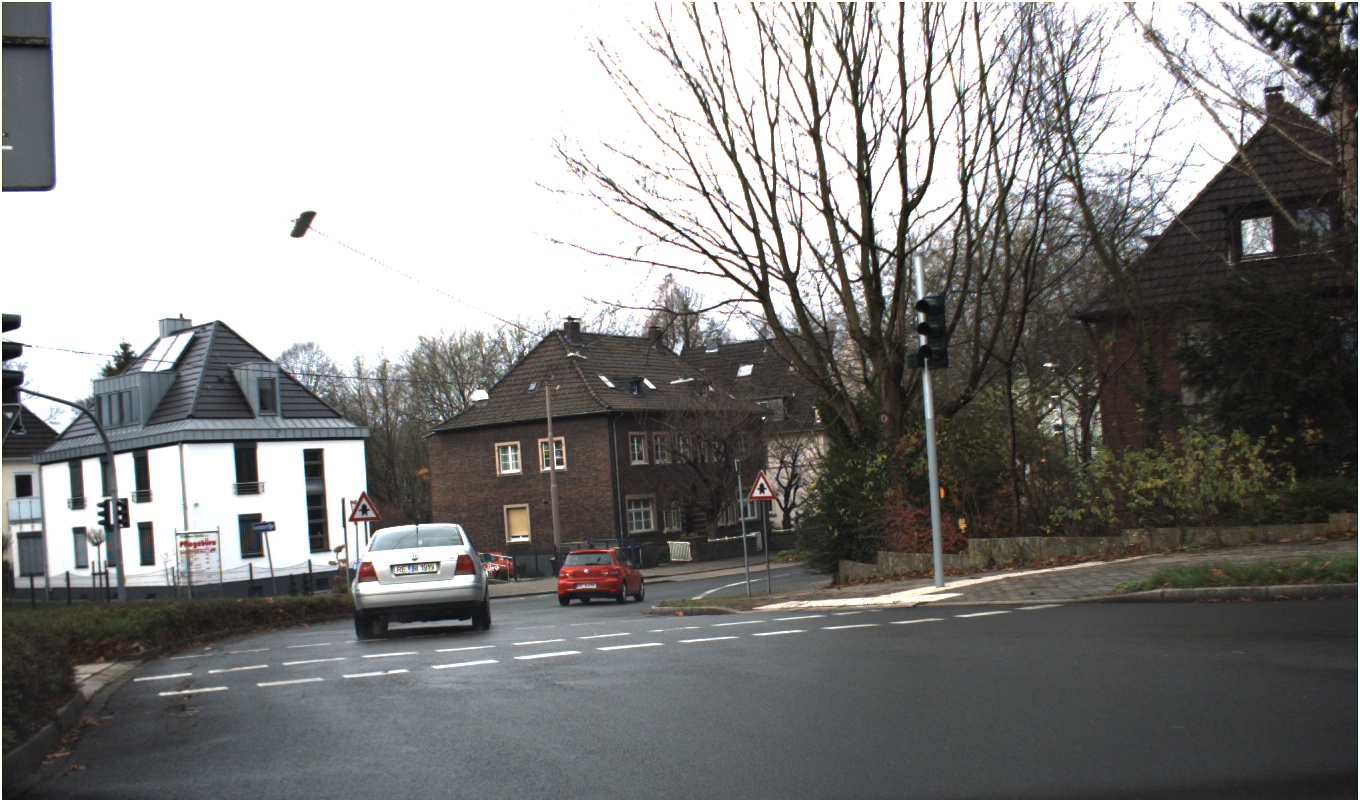

In [18]:
#displaying first three images from the data
#cv2.imshow() is disabled in Colab, because it causes Jupyter sessionsto crash so we imported cv2_imshow according to colab recommendation
from google.colab.patches import cv2_imshow
for i in images[0:3]:
  path=dataset_path + "/" + i #making the path of images
  im = cv2.imread(path)
  # displaying image
  cv2_imshow(im)

In [19]:
text_files[0]

'00246.txt'

In [20]:
#opening the annotation file from directory

ann_file_path=dataset_path + "/" + text_files[0]
file1 = open(ann_file_path, "r")

# Read the file
FileContent = file1.read()
FileContent

'0 0.24448529411764705 0.50375 0.03161764705882353 0.055\n0 0.8180147058823529 0.46875 0.03161764705882353 0.0525\n'

Above is the content of every file. In every line at first position label is given while at other four positions coordinates of the object are mentioned. We can see four classes in "classes.names" file in our dataset.(dataset_path="/content/gdrive/My Drive/Kaggle/traffic_signs_detection/ts/ts")

In [21]:
#Now suppose we want to make 80% training and 20% validation sets

total_training_images=total_images * 0.8
total_val_images= total_images * 0.2

print(total_training_images)
print(total_val_images)

592.8000000000001
148.20000000000002


In [22]:
#onverting in integers
total_training_images=int(total_training_images)
total_val_images=int(total_val_images)

print(f"No of training images: {total_training_images}")
print(f"No of test images: {total_val_images}")

No of training images: 592
No of test images: 148


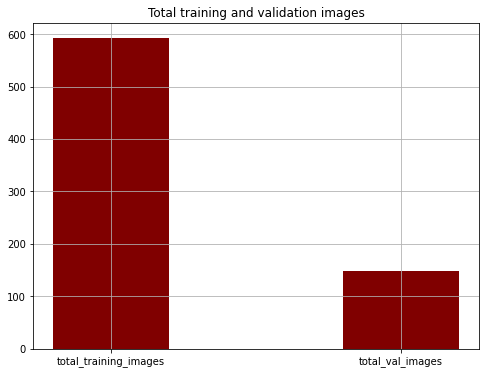

In [23]:
#total number of training and validation images

dict1={"total_training_images":int(total_training_images),"total_val_images":int(total_val_images)}
keys=dict1.keys()
values=dict1.values()
                                 
plt.figure(figsize=(8,6))
plt.bar(keys,values,color ='maroon',
        width = 0.4)

plt.title("Total training and validation images")
plt.grid()
plt.show()

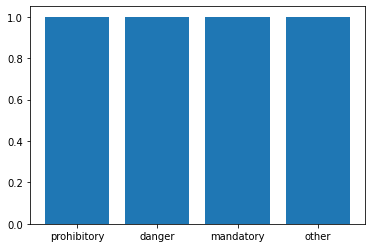

In [24]:
#classes
total_classes=["prohibitory","danger","mandatory","other"]

plt.bar(total_classes,height=1)
plt.show()

In [25]:
range(total_training_images)

range(0, 592)

In [26]:
#randomly select images and put them to multiple folders i.e train,test,train labels and test labels.(We will get the labels from text file)
import os
import random
import shutil 
#import glob

#making directory of folders to save images and labels according to yolov5 requirements
#First we manually have to make folders in the drive.A data folder which have two folders known as images and labels. The image folder have further train and val folders#################
#while labels folder have further train and val folders###########################
#Now mentioning the directory of the folders that we made manually
train_img="/content/gdrive/My Drive/Kaggle/traffic_signs_detection/data/images/train"
test_img="/content/gdrive/My Drive/Kaggle/traffic_signs_detection/data/images/val"
train_labels="/content/gdrive/My Drive/Kaggle/traffic_signs_detection/data/labels/train"
test_labels="/content/gdrive/My Drive/Kaggle/traffic_signs_detection/data/labels/val"

#making the folders for training set
for i in range(total_training_images):


  im_name=random.choice(images) # taking name of random image from image list
  shutil.copy(os.path.join(dataset_path,im_name),os.path.join(train_img,im_name))#copying from orignal folder to mentioned path
  images.remove(im_name)#removing the image from the list memory to prevent these images from copying again in validation set
  
  
  
  txtf_name=im_name[0:5]+".txt" #taking the name of corresponding(corresponding to the image(im_name)) text/annotation file  
  shutil.copy(os.path.join(dataset_path,txtf_name),os.path.join(train_labels,txtf_name))#copying from orignal folder to mentioned path
  text_files.remove(txtf_name)#removing the text file from the list memory to prevent these text files from copying again in validation set

In [27]:
len(images)#we can check that copied images are removed from the list

149

In [28]:
len(text_files)

149

In [30]:
range(total_val_images)

range(0, 148)

In [31]:

#making the folders for validation set
#making the folders for training set
#for j in range(total_training_images):

#  if len(images)>=2:



#    im_name=random.choice(images) # taking name of random image from image list
#    shutil.copy(os.path.join(dataset_path,im_name),os.path.join(test_img,im_name))#copying from orignal folder to mentioned path
#    images.remove(im_name)#removing the image from the list memory to prevent these images from copying again in test set
  
  
  
#    txtf_name=im_name[0:5]+".txt" #taking the name of corresponding(corresponding to the image(im_name)) text/annotation file  
#    shutil.copy(os.path.join(dataset_path,txtf_name),os.path.join(test_labels,txtf_name))#copying from orignal folder to mentioned path
#    text_files.remove(txtf_name)#removing the text file from the list memory to prevent these text files from copying again in test set

#  else:

#    #copying the remaining 1 images and text files in the required directory
#    for image in images:

#      shutil.copy(os.path.join(dataset_path,image),os.path.join(test_img,image))#copying from orignal folder to mentioned path

#    for file1 in text_files:
#      shutil.copy(os.path.join(dataset_path,file1),os.path.join(test_labels,file1))#copying from orignal folder to mentioned path


In [32]:
#len(images)#to check that all files are copied or not

In [33]:
#len(text_files)#to check that all files are copied or not

In [34]:
#copying the remaining 149 images and text files in the required directory
for image in images:
  shutil.copy(os.path.join(dataset_path,image),os.path.join(test_img,image))#copying from orignal folder to mentioned path

for file1 in text_files:
  shutil.copy(os.path.join(dataset_path,file1),os.path.join(test_labels,file1))#copying from orignal folder to mentioned path





An important file is required to work with yolov5. We give this file a name of "data.yaml" file. After making this file we will place it in "data" folder. In this file we have to define the path of "train" and "val" images."nc" is number of classes and "names" is the list of names of different classes. In my case here is nc,names,train and val parameters of this file:


#######total classes(different calssis of traffic signs)

nc: 4
########names of those four classes

names: ["yield","mandatory","speed limit","others"]


########Path of our training and validation immages

train: /content/gdrive/My Drive/Kaggle/traffic_signs_detection/data/images/train

val: /content/gdrive/My Drive/Kaggle/traffic_signs_detection/data/images/val


In [35]:
pwd #we have to work in yolov5 folder

'/content/gdrive/My Drive/Kaggle/traffic_signs_detection/yolov5'

In [36]:
ls #different folders in yolov5 folders

CONTRIBUTING.md  Dockerfile  LICENSE    requirements.txt  utils/
data/            export.py   models/    train.py          val.py
detect.py        hubconf.py  README.md  tutorial.ipynb


In [37]:
#We are working in yolov5 folder
#training our data
!python train.py --img 415 --batch 16 --epochs 50 --data data.yaml --weights yolov5s.pt --cache

#train.py: is responsible for training algoritham on data. This file exist in yolov5 folder as we are working in this directory
#img 415:is size of image
#batch 20: is total number of batches
#epochs 50: 50 is number of epochs
#data data.yaml:data.yaml is our data.yaml file that exist in data folder. This file will give info of data i.e classes and data directory
#weights yolov5s.pt: Initially starting our training from pre trained weights. This file exists in yolov5 folder


train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=50, batch_size=16, imgsz=415, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, entity=None, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 227 (delta 146), reused 139 (delta 134), pack-reused 65
Receiving objects: 100% (227/227), 78.83 KiB | 159.00 KiB/s, done.
Resolving deltas: 100% (161/161), completed with 23 local objects.
github: Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
Traceback (m